✅ Data loaded successfully!
Shape: (125175, 21)
Columns: ['open', 'high', 'low', 'close', 'volume', 'RSI', 'MACD', 'Signal', 'EMA20', 'EMA50', 'EMA200', 'BB_Upper', 'BB_Lower', 'ATR', 'TP', 'Cum_Volume', 'Cum_VolPrice', 'VWAP', 'Return_1', 'Volatility_20', 'Market_State']
📊 Using 19 features: ['open', 'high', 'low', 'volume', 'RSI', 'MACD', 'Signal', 'EMA20', 'EMA50', 'EMA200', 'BB_Upper', 'BB_Lower', 'ATR', 'TP', 'Cum_Volume', 'Cum_VolPrice', 'VWAP', 'Return_1', 'Volatility_20']
🧮 Input shape: (125115, 60, 19)
Training samples: 100092, Testing samples: 25023


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            21504     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 gru (GRU)      

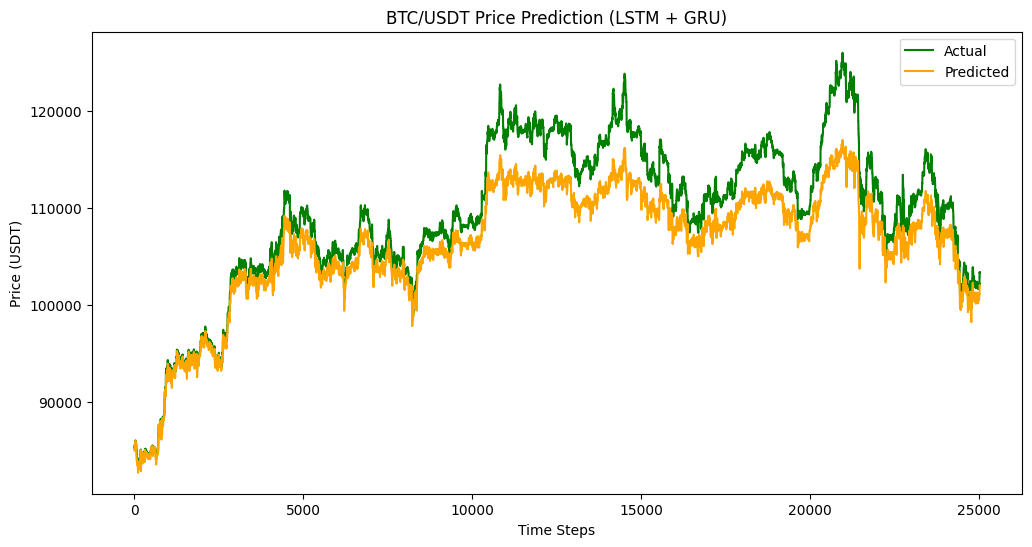

💾 Model and scalers saved successfully!
✅ Phase 3 completed successfully!


In [4]:
# ================================================================
# 📦 Phase 3: Model Training (LSTM + GRU)
# ================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# ================================================================
# 1. Load Data
# ================================================================
file_path = r"C:\Users\himan\OneDrive\Documents\crypto-project\outputs\features_BTCUSDT_1h.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"❌ File not found at {file_path}")

df = pd.read_csv(file_path, parse_dates=["time"])
df.set_index("time", inplace=True)

print("✅ Data loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# ================================================================
# 2. Clean & Prepare Features
# ================================================================
# Drop non-numeric columns
if "Market_State" in df.columns:
    df.drop(columns=["Market_State"], inplace=True)

# Define target
TARGET = "close"
if TARGET not in df.columns:
    raise ValueError(f"❌ Target column '{TARGET}' not found!")

# Features = all numeric columns except target
FEATURES = [col for col in df.columns if col != TARGET]
print(f"📊 Using {len(FEATURES)} features:", FEATURES)

# ================================================================
# 3. Scale the Data
# ================================================================
X = df[FEATURES].values
y = df[TARGET].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# ================================================================
# 4. Create Sequences for LSTM
# ================================================================
def create_sequences(X, y, window_size=60):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i - window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window_size = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)
print("🧮 Input shape:", X_seq.shape)

# ================================================================
# 5. Split Data
# ================================================================
split_ratio = 0.8
split_idx = int(len(X_seq) * split_ratio)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# ================================================================
# 6. Define LSTM-GRU Model
# ================================================================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ================================================================
# 7. Train Model
# ================================================================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# ================================================================
# 8. Evaluate Model
# ================================================================
loss = model.evaluate(X_test, y_test)
print(f"✅ Final Test Loss (MSE): {loss:.6f}")

# ================================================================
# 9. Predictions
# ================================================================
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# ================================================================
# 10. Plot Results
# ================================================================
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual", color="green")
plt.plot(y_pred_inv, label="Predicted", color="orange")
plt.title("BTC/USDT Price Prediction (LSTM + GRU)")
plt.xlabel("Time Steps")
plt.ylabel("Price (USDT)")
plt.legend()
plt.show()

# ================================================================
# 11. Save Scalers
# ================================================================
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

print("💾 Model and scalers saved successfully!")
print("✅ Phase 3 completed successfully!")
